In this lab we'll go beyond standard data analysis and actually code a machine learning algorithm from scratch. As this is our first such exercise we'll start with a classic linear model, Logistic Regression. We'll accomplish this with the following steps:

1. Build a class that can fit a Logistic Regression given training data as well as make predictions on examples without labels
2. Write a unit test that confirms our class produces the correct estimates on synthetically generated data
3. Benchmark our class against SkLearn for speed and accuracy

# A Logistic Class

Before we do any programming, we need to first understand the optimization algorithm we'll use. As a reference, we'll be following the presentation presented here: https://tminka.github.io/papers/logreg/minka-logreg-old.pdf.

The logistic loss is convex so we'll use a convex optimization process called gradient descent. In particular, we will use a variant called Newton's Method that uses the 2nd derivative of the loss function to set the learning rate. To start, here are some primitives:

<b>$L = \sum y * ln(p) + (1-y)*ln(1-p)$</b>

(Note, we'll drop subscripts over the data instances to keep notation simple. All sums are over examples in the data set.)

<b> $g_j = \nabla L_j = \sum (y-p)*x_j$</b>

(This is the 1st derivative, where $j$ indicates feature dimension $j$)

<b> $H_{jk} = \sum p*(1-p)*x_j*x_k$</b>

(This is the 2nd derivative w.r.t. features $j$ and $k$)

Now the general form of Gradient Descent follows this function:

<b>$w_{new} = w_{old} - \nu * g$</b>

Where $w$ is the weight and $\nu$ is an appropriately chosen step size. In our case, we're going to use the inverse of the 2nd derviative matrix (the Hessian) as our learning rate. If we define $H$ as the Hessian matrix with entries $H_{jk}$ from above, and $G$ a gradient vector who's $jth$ entry is $g_j$, then our optimization problem becomes:

<b>$w_{new} = w_{old} - H^{-1} * G$</b>

This is what we are going to program here. Let's define a class that has the following methods:

1. An __init__ method that takes in an error tolerence as a stopping criterion, as well as max number of iterations.
2. A <b>predict</b> method that takes a given matrix X and predicts $p=(1+e^{(-X*B)})^{-1}$ for each entry
3. A <b>compute_gradient</b> method that computes the gradient vector $G$
4. A <b>compute_hessian</b> method that computes the Hessian. Note that the $H$ can be broken down to the following matrix multiplcation: $H=X^TQX$, where $X$ is the input matrix and $Q$ is a diagonal matrix where each entry $Q_{ii}=p_i*(1-p_i)$.
5. An <b>update_weights</b> method that applies Newton's method to update the weights
6. A <b>check_stop</b> method that checks whether the model has converged or the max iterations have been met
7. A <b>fit</b> method that takes in the data and runs the gradient optimization


In [1]:
#write a class with the following API
import numpy as np


class MyFirstLogReg(object):
    
    def __init__(self, tol = 10**-8, max_iterations = 20):
        
        self.tolerance = tol
        self.max_iterations = max_iterations
        self.beta = None
        self.alpha = 0
        
    def predict(self, Xint):
        '''
        Compute probs using the inverse logit
        - Inputs: The NxK X matrix
        - Outputs: Vector of probs of length N
        '''
        
        #First compute X*beta+alpha
        XB = Xint.dot(self.b) 
        return (1+np.exp(-1*XB))**-1
        
    def compute_gradient(self, Xint, y, p):
        '''
        Computes the gradient vector
        -Inputs:
            - NxK X matrix
            - Nx1 y (label) vector
            - Nx1 ps vector of predictions
        -Outputs: 1xK vector of gradients
        '''
        return (y-p).dot(Xint)
        
    def compute_hessian(self, Xint, P):
        '''
        computes the Hessian matrix
        -inputs:
            - NxK X matrix
            - Nx1 vector of predictions
        -outputs:
            - KxK Hessian matrix H=X^T * Diag(Q) * X
        '''
        #Note, in first 
        Q = np.diag(P*(1-P))
        return (Xint.T).dot(Q).dot(Xint)


    def update_weights(self, Xint, y, i):
        '''
        Updates existing weight vector
        -Inputs:
            -NxK X matrix
            -Nx1 y vector
        -updates weights by calling predict, compute_gradient and compute_hessian
        '''
        p = self.predict(Xint)
        g = self.compute_gradient(Xint, y, p)
        H = self.compute_hessian(Xint, p)
                
        #Store the current weights before updating so we can check for convergence
        self.prior_b = self.b
        
        #update the weights
        self.b = self.b + np.linalg.inv(H).dot(g)
        
        
    def check_stop(self):
        '''
        check to see if euclidean distance between old and new weights (normalized)
        is less than the tolerance
        
        returns: True or False on whether stopping criteria is met
        '''
        b_old_norm = self.prior_b / (np.sqrt(self.prior_b.dot(self.prior_b)))
        b_new_norm = self.b / (np.sqrt(self.b.dot(self.b)))
        diff = b_new_norm - b_old_norm
        return (np.sqrt(diff.dot(diff)) < self.tolerance)
        
        
    def fit(self, X, y):
        '''
        X is the Nx(K-1) data matrix
        Y is the labels, using {0,1} coding
        '''
        
        #set initial weights - add an extra dimension for the intercept
        self.b = np.zeros(X.shape[1] + 1)
        
        #Initialize the slope parameter to log(base rate/(1-base rate))
        self.b[-1] = np.log(y.mean() / (1-y.mean()))
        
        #create a new X matrix that includes a column of ones for the intercept
        Xint = np.hstack((X, np.ones((X.shape[0],1))))

        for i in range(self.max_iterations):
            #print(i)
            self.update_weights(Xint, y, i)
            self.beta = self.b[0:-1]
            self.alpha = self.b[-1]
            if self.check_stop():
                break
            
        

Note about testing

One way we can test this implementation is to generate some random data according to a logistic model, and see if our model returns the correct weights. To do this:


* generate an NxK X matrix of random numbers
* generate a 1xK weight vector called Beta
* set alpha
* Given Beta and Alpha, compute P(Y|X) using the logistic function
* Generate an Nx1 random sequence in [0,1], and set Y=1 if R_i < P_i


In [2]:
#Generate a dataset with N=10k and K=5
def gen_logistic(N, K, Beta, Alpha):
    X = np.random.random((N,K))
    XB = X.dot(Beta) + Alpha * np.ones(N)
    P = (1 + np.exp(-1*XB))**-1
    Y = (np.random.random(N) < P)
    return X, Y

K = 2

Beta = 2*(np.random.random(K)-1)
Alpha = -1

X, Y = gen_logistic(1000, K, Beta, Alpha)

In [3]:
X

array([[0.27108961, 0.31179477],
       [0.30245465, 0.35250667],
       [0.08182556, 0.37421121],
       ...,
       [0.91922319, 0.70891084],
       [0.19119295, 0.00195363],
       [0.97147499, 0.12276945]])

Now that we have our dataset, let's test out our algorithm

In [4]:
lr = MyFirstLogReg()
lr.fit(X, Y)

In [5]:
print('The real Betas and Alpha are:')
print(Beta, Alpha)
print('')
print('The fitted Betas and Alpha are:')
print(lr.beta, lr.alpha)


The real Betas and Alpha are:
[-1.96887433 -1.49809145] -1

The fitted Betas and Alpha are:
[-2.03901226 -0.71931536] -1.1552036380557729


Now let's compare our fitted results to SkLearn's Logistic Regression implementation

In [6]:
from sklearn.linear_model import LogisticRegression

LR_SK = LogisticRegression(C=10**10).fit(X,Y)
LR_SK.coef_, LR_SK.intercept_

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(array([[-2.0390111 , -0.71931524]]), array([-1.15520359]))

We can see that this is pretty close, though not exact at all digits of precision.  We can also see that both systems produce estimates that are far from the truth. Does this mean that the code is correct? If it is indeed correct, why might we observe the above? We can write a more robust test by running multiple draws, and seeing if on average we get the right answer. We can also increase the sample size. Doing either will be more computationally expensive. Before going there let's profile our code to see if there is a way to optimize it.

In [7]:
import cProfile
cProfile.run('lr.fit(X, Y)')

         266 function calls (264 primitive calls) in 0.053 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_1d)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(concatenate)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
        5    0.000    0.000    0.020    0.004 <__array_function__ internals>:2(diag)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(hstack)
        5    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(inv)
        5    0.001    0.000    0.001    0.000 <ipython-input-1-88f1d3c89ec0>:14(predict)
        5    0.000    0.000    0.008    0.002 <ipython-input-1-88f1d3c89ec0>:25(compute_gradient)
        5    0.000    0.000    0.035    0.007 <ipython-input-1-88f1d3c89ec0>:36(compute_hessian)
        5    0.006  

What method is taking the most amount of time? Looking more closely at the exact sequence of operations, what might be taking up a lot of memory or time? How can we achieve the same mathematic results, but do it in a more memory friendly way?

Let's do a quick test, where we design an alternative, and hopefully faster way to compute the Hessian.

## This is a good place to break. Part 2 in the next lab

In [8]:
def hessian_slow(X, P):
    '''
    Copy the operations used in the class above
    '''
    Q = np.diag(P*(1-P))
    return (X.T).dot(Q).dot(X)
    
    
def hessian_fast(X, P):
    '''
    Rewrite this without using the np.diag function
    '''
    Q = P*(1-P)
    XQ = X.T * Q
    return XQ.dot(X)


In [9]:
P = 0.5 * np.ones(X.shape[0])
%timeit hessian_slow(X, P)

2.95 ms ± 277 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit hessian_fast(X, P)

19.2 µs ± 164 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Does this make a difference? Now create a new class, same as above, but overwrite the compute_hessian method with the above faster version. We're going to do this in a very light and efficient way. Essentially we'll inherit MyFirstLogReg class, which means all of the methods in the base class are callable for this one. We can overwrite the compute_hessian method with our faster approach (note, in normal software development we'd likely just revise the original class, but we're doing it this way to show the example).

In [11]:

class MyFasterFirstLogReg(MyFirstLogReg):
    
    def compute_hessian(self, Xint, p):
        '''
        computes the Hessian matrix
        -inputs:
            - NxK X matrix
            - Nx1 vector of predictions
        -outputs:
            - KxK Hessian matrix H=X^T * Diag(Q) * X
        '''
        Q = p*(1-p)
        XintQ = Xint.T * Q
        return XintQ.dot(Xint)


    

In [12]:
#Now rerun
lr = MyFasterFirstLogReg()
lr.fit(X, Y)

In [13]:
lr.beta, lr.alpha

(array([-2.03901226, -0.71931536]), -1.1552036380557729)

As one last speed test, let's compare our faster class to sklearn.

In [14]:
%timeit LogisticRegression().fit(X,Y)

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

2.24 ms ± 898 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

In [15]:
%timeit MyFasterFirstLogReg().fit(X, Y)

717 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Now that we've got an efficient class written, let's perform 3 different unit tests:
* Compare the results to SkLearn. This replicates a scenario where for some reason we can't use the SkLearn package and had to write our own code. Since SkLearn does exist, we can at least benchmark against it.
* Run it once just on a much larger data set (which should come close to the truth value).
* Run it many times over different draws from the same data generating distribution and look at the distribution of outcomes.

In [16]:
#First let's generate a dataset with 1000000 examples
K = 4
Beta = 2*(np.random.random(K)-1)
Alpha = -2

X, Y = gen_logistic(1000000, K, Beta, Alpha)

In [17]:
LR_SK = LogisticRegression(C=10**30).fit(X,Y)
LR_Mine = MyFasterFirstLogReg()
LR_Mine.fit(X, Y)

/Users/kathleenyoung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
print('Truth: beta=' + str(LR_SK.coef_) + ', Alpha=' +str(Alpha))
print('SkLearn: beta=' + str(LR_SK.coef_) + ', Alpha=' +str(Alpha))
print('Ours: beta=' + str(LR_Mine.beta) + ', Alpha=' +str(LR_Mine.alpha))

Truth: beta=[[-0.63382449 -1.757231   -0.39789695 -1.85618153]], Alpha=-2
SkLearn: beta=[[-0.63382449 -1.757231   -0.39789695 -1.85618153]], Alpha=-2
Ours: beta=[-0.63374212 -1.75718162 -0.39798071 -1.85624916], Alpha=-2.022055601394373


For this test we'll check whether on average our own LR class is correct. To do this, run a loop where in each iteration, generate a random data set of size N, using the same Beta and Alpha. Then fit the model and store the weights. After this runs we can look at the distributions of features.

In [19]:
betas = []
alphas = []

for i in range(10000):
    X, Y = gen_logistic(10000, K, Beta, Alpha)
    LR_Mine = MyFasterFirstLogReg()
    LR_Mine.fit(X, Y)
    betas.append(LR_Mine.beta)
    alphas.append(LR_Mine.alpha)

Now plot the histograms of each parameter distribution

In [20]:
#First put it all in a dataframe
import pandas as pd
df = pd.DataFrame(betas, columns = ['b' + str(k) for k in range(K)])
df['alpha'] = alphas

In [21]:
#Let's check the means against the truth
df.mean(), Beta, Alpha

(b0      -0.651969
 b1      -1.737023
 b2      -0.416677
 b3      -1.891484
 alpha   -2.010330
 dtype: float64,
 array([-0.65405657, -1.73495864, -0.41037654, -1.88308852]),
 -2)

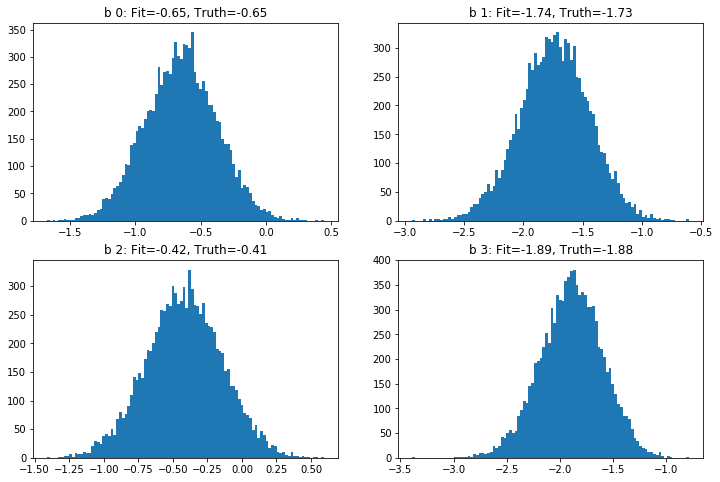

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

bmeans = df.mean()
fig = plt.figure(figsize=(12,8))
for i in range(K):
    fig.add_subplot(2,2,i+1)
    plt.hist(df['b'+str(i)], bins=100)
    plt.plot()
    plt.title('b {}: Fit={}, Truth={}'.format(i, np.round(bmeans[i],2), np.round(Beta[i],2)))
    